# Modelling & Training

In this notebook we are going to structure and train the models needed for the SpotMask software.

1. Mask Detection (mask vs no mask)
2. Mask Correctness (proper vs improper)
3. Mask Suggestions (nose / mouth / chin / proper / off)

## Preparatory Steps

Then we import base libraries that we will need

In [1]:
# General
import os
from IPython.display import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

In case of need to ignore the **local GPU** for memory limits or other reasons we can run the following code.

In [2]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

Importing ```TensorFlow``` libraries

In [3]:
# TensorFlow
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

Subsequently we set up our base dir. 
Feel free to change the *base_dir* with the project folder on your machine. In our case will remain the main project folder obtained from the github repository.

We report here below the snippet if required

```! git clone https://github.com/JacopoBugini/SpotMask.git```

We set then the path to the base folder, in our case the downloaded repo ```SpotMask```

In [4]:
#path to the folder on your machine
base_dir = '' 

**Remember to download the datasets first and copy them inside the dataset folder before executing the code as explained in details in the Report (Section 2.2)**

____

## 1. Mask Detection

We want to build a model able to detect if a mask is present or not on a specific individual, without checking its actual correctness.

For this reason we will need to train a net with 2 outputs:
1. Mask Detected
2. No Mask Detected

### Mask Detection Model Set-Up

The model chosen is a sequential CNN with the following structure:

In [5]:
detection_model = models.Sequential()

detection_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
detection_model.add(layers.MaxPooling2D((2, 2)))

detection_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
detection_model.add(layers.MaxPooling2D((2, 2)))

detection_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
detection_model.add(layers.MaxPooling2D((2, 2)))

detection_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
detection_model.add(layers.MaxPooling2D((2, 2)))

detection_model.add(layers.Flatten())

detection_model.add(layers.Dropout(rate=0.5))

detection_model.add(layers.Dense(512, activation='relu'))
detection_model.add(layers.Dense(2, activation='softmax'))

In [6]:
detection_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

We now compile the model

In [7]:
detection_model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

### Dataset

We now set up the dataset path for the first model and all the necessary preparatory steps.

In [8]:
dataset = os.path.join(base_dir, 'dataset\\detect_mask_dataset')

Set base directory for each process step

In [9]:
train_dir = os.path.join(dataset, 'train')
validation_dir = os.path.join(dataset, 'validation')
test_dir = os.path.join(dataset, 'test')

We now proceed with a quick summary of the data present in the directories

In [10]:
print("********************************************************")
print("TRAINING SET")
print("********************************************************")
print("Dir:", train_dir, '\n')
train_mask_dir = os.path.join(train_dir, 'mask')
train_no_mask_dir = os.path.join(train_dir, 'no_mask')
print("Images (#)")
print("Mask:", len(os.listdir(train_mask_dir)))
print("No Mask:", len(os.listdir(train_no_mask_dir)), '\n')

print("********************************************************")
print("VALIDATION SET")
print("********************************************************")
print("Dir:", validation_dir, '\n')
validation_mask_dir = os.path.join(validation_dir, 'mask')
validation_no_mask_dir = os.path.join(validation_dir, 'no_mask')
print("Images (#)")
print("Mask:", len(os.listdir(validation_mask_dir)))
print("No Mask:", len(os.listdir(validation_no_mask_dir)), '\n')

print("********************************************************")
print("TEST SET")
print("********************************************************")
print("Dir:", test_dir, '\n')
test_mask_dir = os.path.join(test_dir, 'mask')
test_no_mask_dir = os.path.join(test_dir, 'no_mask')
print("Images (#)")
print("Mask:", len(os.listdir(test_mask_dir)))
print("No Mask:", len(os.listdir(test_no_mask_dir)))

********************************************************
TRAINING SET
********************************************************
Dir: dataset\detect_mask_dataset\train 

Images (#)
Mask: 30000
No Mask: 30000 

********************************************************
VALIDATION SET
********************************************************
Dir: dataset\detect_mask_dataset\validation 

Images (#)
Mask: 14000
No Mask: 14000 

********************************************************
TEST SET
********************************************************
Dir: dataset\detect_mask_dataset\test 

Images (#)
Mask: 10000
No Mask: 10000


### Model Training

For the training phase we decide to apply a few transofrmation to the training dataset in order to be able to better generalize. We noticed that light exposure in real environments are quite significant, hence we added a **brightness** transformation factor as well.

In [11]:
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.3,1.0],
    horizontal_flip=True)

train_generator_augmented = train_datagen_augmented.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=75,
        class_mode='categorical')

Found 60000 images belonging to 2 classes.


In [12]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
        validation_dir, # validation directory
        target_size=(150, 150),
        batch_size=40,
        class_mode='categorical')

Found 28000 images belonging to 2 classes.


In [13]:
for data_batch, labels_batch in train_generator_augmented:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (75, 150, 150, 3)
labels batch shape: (75, 2)


We then train our first model.

Note that we do not use any early stopper due to short training time thanks to the GPU and limited number of epochs due to fast convergence.

In [14]:
history = detection_model.fit(
    train_generator_augmented,
    steps_per_epoch=400,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=30
)

Epoch 1/10
400/400 [==============================] - 385s 951ms/step - loss: 0.6421 - acc: 0.6232 - val_loss: 0.1675 - val_acc: 0.9717
Epoch 2/10
400/400 [==============================] - 354s 885ms/step - loss: 0.2552 - acc: 0.9157 - val_loss: 0.1128 - val_acc: 0.9750
Epoch 3/10
400/400 [==============================] - 352s 881ms/step - loss: 0.2084 - acc: 0.9333 - val_loss: 0.0223 - val_acc: 0.9958
Epoch 4/10
400/400 [==============================] - 353s 882ms/step - loss: 0.1836 - acc: 0.9428 - val_loss: 0.0503 - val_acc: 0.9892
Epoch 5/10
400/400 [==============================] - 338s 845ms/step - loss: 0.1714 - acc: 0.9458 - val_loss: 0.0303 - val_acc: 0.9917
Epoch 6/10
400/400 [==============================] - 327s 817ms/step - loss: 0.1576 - acc: 0.9513 - val_loss: 0.0716 - val_acc: 0.9883
Epoch 7/10
400/400 [==============================] - 324s 809ms/step - loss: 0.1450 - acc: 0.9554 - val_loss: 0.0556 - val_acc: 0.9800
Epoch 8/10
400/400 [============================

Saving the model

In [15]:
detection_model.save('models/mask-detection/mask_detection_model.h5') 

Printing accuracy metrics in the training and validation phase

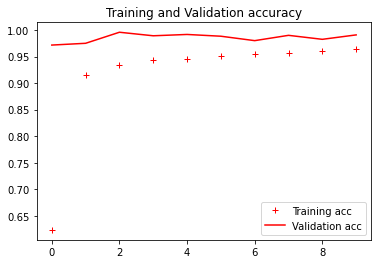

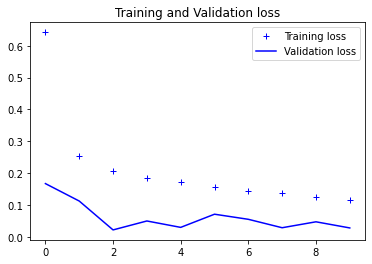

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r+', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b+', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

The validation accuracy is constantly higher than the training accuracy due to the dropout layer that is very harsh in the training phase.

### Evaluate Model

In [17]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=30,
        class_mode='categorical')

Found 20000 images belonging to 2 classes.


In [18]:
scores = detection_model.evaluate(test_generator, verbose=0)

In [19]:
print("%s: %.2f%%" % (detection_model.metrics_names[1], scores[1]*100))

acc: 98.81%


____

## 2. Mask Correctness

We want to build a model able to detect if a mask is present or not on a specific individual, without checking its actual correctness.

For this reason we will need to train a net with 2 outputs:
1. **Proper**
2. **Improper**

### Mask Correctness Model Set-Up

The model chosen is a sequential CNN with the following structure:

In [22]:
mask_correctness = models.Sequential()

mask_correctness.add(layers.Conv2D(128, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
mask_correctness.add(layers.MaxPooling2D((2, 2)))

mask_correctness.add(layers.Conv2D(128, (3, 3), activation='relu'))
mask_correctness.add(layers.MaxPooling2D((2, 2)))

mask_correctness.add(layers.Conv2D(64, (3, 3), activation='relu'))
mask_correctness.add(layers.MaxPooling2D((2, 2)))

mask_correctness.add(layers.Conv2D(64, (3, 3), activation='relu'))
mask_correctness.add(layers.MaxPooling2D((2, 2)))

mask_correctness.add(layers.Flatten())

mask_correctness.add(layers.Dropout(rate=0.5))

mask_correctness.add(layers.Dense(50, activation='relu'))
mask_correctness.add(layers.Dense(2, activation='softmax'))

In [23]:
mask_correctness.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 128)     3584      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 128)       147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 64)        73792     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 64)       

And we compile the model as well:

In [24]:
mask_correctness.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

### Dataset

We now set up the dataset path for the first model and all the necessary preparatory steps.

In [25]:
dataset = os.path.join(base_dir, 'dataset\\mask_correctness_dataset')

Set base directory for each process step

In [26]:
train_dir = os.path.join(dataset, 'train')
validation_dir = os.path.join(dataset, 'validation')
test_dir = os.path.join(dataset, 'test')

We now proceed with a quick summary of the data present in the directories

In [28]:
print("********************************************************")
print("TRAINING SET")
print("********************************************************")
print("Dir:", train_dir, '\n')
train_proper_dir = os.path.join(train_dir, 'proper')
train_improper_dir = os.path.join(train_dir, 'improper')
print("Images (#)")
print("Proper:", len(os.listdir(train_proper_dir)))
print("Improper:", len(os.listdir(train_improper_dir)), '\n')

print("********************************************************")
print("VALIDATION SET")
print("********************************************************")
print("Dir:", validation_dir, '\n')
validation_proper_dir = os.path.join(validation_dir, 'proper')
validation_improper_dir = os.path.join(validation_dir, 'improper')
print("Images (#)")
print("Proper:", len(os.listdir(validation_proper_dir)))
print("Improper:", len(os.listdir(validation_improper_dir)), '\n')

print("********************************************************")
print("TEST SET")
print("********************************************************")
print("Dir:", test_dir, '\n')
test_proper_dir = os.path.join(test_dir, 'proper')
test_improper_dir = os.path.join(test_dir, 'improper')
print("Images (#)")
print("Proper:", len(os.listdir(test_proper_dir)))
print("Improper:", len(os.listdir(test_improper_dir)))

********************************************************
TRAINING SET
********************************************************
Dir: dataset\mask_correctness_dataset\train 

Images (#)
Proper: 30000
Improper: 30000 

********************************************************
VALIDATION SET
********************************************************
Dir: dataset\mask_correctness_dataset\validation 

Images (#)
Proper: 4000
Improper: 4000 

********************************************************
TEST SET
********************************************************
Dir: dataset\mask_correctness_dataset\test 

Images (#)
Proper: 9000
Improper: 9000


### Preprocessing

In [29]:
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.3,1.0],
    horizontal_flip=True)

train_generator_augmented = train_datagen_augmented.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=50,
        class_mode='categorical')

Found 60000 images belonging to 2 classes.


In [30]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
        validation_dir, # validation directory
        target_size=(150, 150),
        batch_size=30,
        class_mode='categorical')

Found 8000 images belonging to 2 classes.


In [31]:
for data_batch, labels_batch in train_generator_augmented:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (50, 150, 150, 3)
labels batch shape: (50, 2)


### Model Training

In [32]:
history = mask_correctness.fit(
    train_generator_augmented,
    steps_per_epoch=500,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=20
)

Epoch 1/15
500/500 [==============================] - 487s 969ms/step - loss: 0.6885 - acc: 0.5728 - val_loss: 0.6565 - val_acc: 0.5583
Epoch 2/15
500/500 [==============================] - 473s 947ms/step - loss: 0.6183 - acc: 0.6751 - val_loss: 0.3755 - val_acc: 0.8617
Epoch 3/15
500/500 [==============================] - 550s 1s/step - loss: 0.5227 - acc: 0.7472 - val_loss: 0.3810 - val_acc: 0.8050
Epoch 4/15
500/500 [==============================] - 545s 1s/step - loss: 0.4535 - acc: 0.7977 - val_loss: 0.3209 - val_acc: 0.8767
Epoch 5/15
500/500 [==============================] - 491s 982ms/step - loss: 0.4038 - acc: 0.8293 - val_loss: 0.2581 - val_acc: 0.8933
Epoch 6/15
500/500 [==============================] - 446s 892ms/step - loss: 0.3718 - acc: 0.8442 - val_loss: 0.2622 - val_acc: 0.8933
Epoch 7/15
500/500 [==============================] - 434s 867ms/step - loss: 0.3517 - acc: 0.8563 - val_loss: 0.2962 - val_acc: 0.8700
Epoch 8/15
500/500 [==============================] - 

And we save the model

In [33]:
mask_correctness.save('models/facemask-correctness/mask_correctness_model.h5') 

Printing accuracy metrics in the training and validation phase

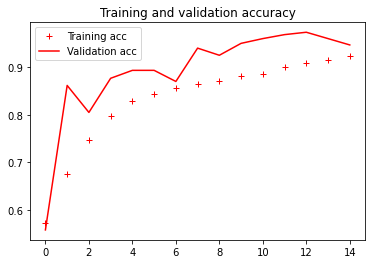

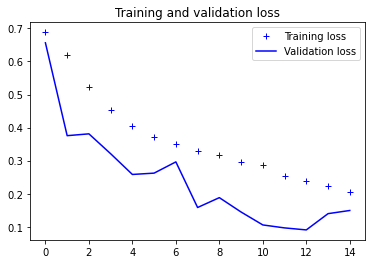

In [35]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r+', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b+', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Evaluate Model

In [36]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=30,
        class_mode='categorical')

Found 18000 images belonging to 2 classes.


In [37]:
scores = mask_correctness.evaluate(test_generator, verbose=0)

In [38]:
print("%s: %.2f%%" % (mask_correctness.metrics_names[1], scores[1]*100))

acc: 94.88%


____

## 3. Suggestions Model

We want now to try classifying the different positions of the mask, trying to substitute the second model with a more precise and informative one.

For this reason we will need to train a net with 4 outputs:
1. **Proper** - The mask is properly worn
2. **Off** - The mask is under the chin not covering any part of the face
3. **Nose** - The mask is worn leaving the nose outside
4. **Chin** - The Mask is covering mouth and nose but is worn incorrectly leaving the chin outside

This time we will try to generate a model utilizing a hyperparameter tuner in oprder to find the most efficient model. You cna read more in the tuning section below.

In [39]:
model_dir = os.path.join(base_dir, 'models\\suggestions-detection')

### Dataset

We now set up the dataset path for the model and all the necessary preparatory steps.

In [40]:
dataset = os.path.join(base_dir, 'dataset\\suggestions_dataset')

Set base directory for each process step

In [41]:
train_dir = os.path.join(dataset, 'train')
validation_dir = os.path.join(dataset, 'validation')
test_dir = os.path.join(dataset, 'test')

We now proceed with a quick summary of the data present in the directories

In [42]:
print("********************************************************")
print("TRAINING SET")
print("********************************************************")
print("Dir:", train_dir, '\n')
train_proper_dir = os.path.join(train_dir, 'proper')
train_off_dir = os.path.join(train_dir, 'off')
train_nose_dir = os.path.join(train_dir, 'nose')
train_chin_dir = os.path.join(train_dir, 'chin')
print("Images (#)")
print("Proper:", len(os.listdir(train_proper_dir)))
print("Off:", len(os.listdir(train_off_dir)))
print("Nose:", len(os.listdir(train_nose_dir)))
print("Chin:", len(os.listdir(train_chin_dir)), '\n')

print("********************************************************")
print("VALIDATION SET")
print("********************************************************")
print("Dir:", validation_dir, '\n')
validation_proper_dir = os.path.join(validation_dir, 'proper')
validation_off_dir = os.path.join(validation_dir, 'off')
validation_nose_dir = os.path.join(validation_dir, 'nose')
validation_chin_dir = os.path.join(validation_dir, 'chin')
print("Images (#)")
print("Proper:", len(os.listdir(validation_proper_dir)))
print("Off:", len(os.listdir(validation_off_dir)))
print("Nose:", len(os.listdir(validation_nose_dir)))
print("Chin:", len(os.listdir(validation_chin_dir)), '\n')

print("********************************************************")
print("TEST SET")
print("********************************************************")
print("Dir:", test_dir, '\n')
test_proper_dir = os.path.join(test_dir, 'proper')
test_off_dir = os.path.join(test_dir, 'off')
test_nose_dir = os.path.join(test_dir, 'nose')
test_chin_dir = os.path.join(test_dir, 'chin')
print("Images (#)")
print("Proper:", len(os.listdir(test_proper_dir)))
print("Off:", len(os.listdir(test_off_dir)))
print("Nose:", len(os.listdir(test_nose_dir)))
print("Chin:", len(os.listdir(test_chin_dir)))

********************************************************
TRAINING SET
********************************************************
Dir: dataset\suggestions_dataset\train 

Images (#)
Proper: 3000
Off: 3000
Nose: 3000
Chin: 3000 

********************************************************
VALIDATION SET
********************************************************
Dir: dataset\suggestions_dataset\validation 

Images (#)
Proper: 1000
Off: 1000
Nose: 1000
Chin: 1000 

********************************************************
TEST SET
********************************************************
Dir: dataset\suggestions_dataset\test 

Images (#)
Proper: 800
Off: 800
Nose: 800
Chin: 800


### Preprocessing

In [43]:
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.3,1.0],
    horizontal_flip=True)

train_generator_augmented = train_datagen_augmented.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=50,
        class_mode='categorical')

Found 12000 images belonging to 4 classes.


In [44]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=30,
        class_mode='categorical')

Found 4000 images belonging to 4 classes.


In [45]:
for data_batch, labels_batch in train_generator_augmented:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (50, 150, 150, 3)
labels batch shape: (50, 4)


### Model Tuning

EXPLAIN WHY TUNING

To do so we will use the package **keras-tuner**.
> O'Malley, T., Bursztein, E., Long, J., Chollet, F., Jin, H., Invernizzi, L., & others. (2019). Keras Tuner. https://github.com/keras-team/keras-tuner.

```! pip install keras-tuner```

In [46]:
import keras_tuner as kt

Firs of all we define our model generator function with the parameters we want to test:

- ```n_layers```: is the number of layers, we set it variable between 1 and 4.
- ```input_units```: are the input nodes in the convolutional layers, varying from 32 to 128 in steps of 32

In [47]:
def create_model(hp):
    
    model = models.Sequential()
    
    model.add(layers.Conv2D(hp.Int("input_units", min_value=32, max_value=128, step=32), (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    for i in range(hp.Int("n_layers", min_value=1, max_value=4)):
        model.add(layers.Conv2D(hp.Int(f"conv_{i}_units", min_value=32, max_value=128, step=32), (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dropout(rate=0.5))
    
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['acc'])
    
    return model

we initialize the tuner and the relevant information needed for the log storage

In [48]:
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
hp = kt.HyperParameters()

In [49]:
hyperparameter_tuning_dir = os.path.join(model_dir, 'hyperparameter-tuning')

In [50]:
LOG_DIR = f"{int(time.time())}"

Then we initialize the random search

In [51]:
tuner_detection = kt.RandomSearch(
    create_model,
    objective = 'val_acc',
    max_trials = 20,
    executions_per_trial = 2,
    directory = os.path.join(hyperparameter_tuning_dir, LOG_DIR)
)

Eventually we execude the tuner research of the best model:

In [52]:
tuner_detection.search(train_generator_augmented,
             epochs=1,
             validation_data=validation_generator)

Trial 20 Complete [00h 08m 04s]
val_acc: 0.43137499690055847

Best val_acc So Far: 0.750124990940094
Total elapsed time: 02h 43m 25s
INFO:tensorflow:Oracle triggered exit


We extract the best model according to the tuner and pass it to the trainin phase.

In [53]:
best_model_suggestions = tuner_detection.get_best_models()[0]

Let's view a summary of the best model found by the tuner:

In [54]:
best_model_suggestions.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 96)        110688    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 96)        0         
_________________________________________________________________
flatten (Flatten)            (None, 27744)             0

### Model Training

In [55]:
history = best_model_suggestions.fit(
    train_generator_augmented,
    steps_per_epoch=240,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=10
)

Epoch 1/20
240/240 [==============================] - 250s 1s/step - loss: 1.1259 - acc: 0.4969 - val_loss: 0.9329 - val_acc: 0.5700
Epoch 2/20
240/240 [==============================] - 201s 836ms/step - loss: 1.0081 - acc: 0.5613 - val_loss: 0.8969 - val_acc: 0.5167
Epoch 3/20
240/240 [==============================] - 202s 842ms/step - loss: 0.9303 - acc: 0.5983 - val_loss: 0.8472 - val_acc: 0.5367
Epoch 4/20
240/240 [==============================] - 200s 832ms/step - loss: 0.8733 - acc: 0.6272 - val_loss: 0.7527 - val_acc: 0.6167
Epoch 5/20
240/240 [==============================] - 200s 833ms/step - loss: 0.8239 - acc: 0.6413 - val_loss: 0.7027 - val_acc: 0.7000
Epoch 6/20
240/240 [==============================] - 200s 832ms/step - loss: 0.7739 - acc: 0.6620 - val_loss: 0.6908 - val_acc: 0.7267
Epoch 7/20
240/240 [==============================] - 200s 831ms/step - loss: 0.7390 - acc: 0.6871 - val_loss: 0.4961 - val_acc: 0.7933
Epoch 8/20
240/240 [==============================]

In [56]:
best_model_suggestions.save('models/suggestions-detection/suggestions_model.h5') 

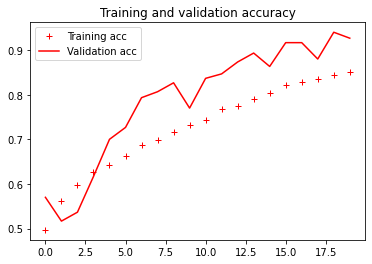

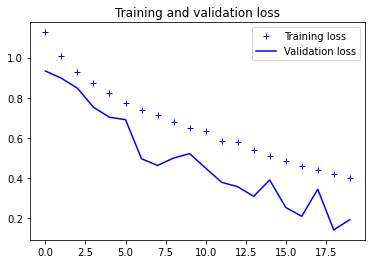

In [57]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r+', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b+', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Evaluate Model

In [58]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=30,
        class_mode='categorical')

Found 3200 images belonging to 4 classes.


In [59]:
scores = best_model_suggestions.evaluate(test_generator, verbose=0)

In [60]:
print("%s: %.2f%%" % (best_model_suggestions.metrics_names[1], scores[1]*100))

acc: 92.53%
